In [1]:
import cudf
import nvtabular as nvt

import warnings
warnings.filterwarnings("ignore")

# Basic `Categorify` workflow

In [2]:
gdf = cudf.DataFrame(data=[['apple'], ['apple'], ['orange']], columns=['item'])
gdf

,item
0,apple
1,apple
2,orange


In [3]:
output = ['item'] >> nvt.ops.Categorify()

In [4]:
workflow = nvt.Workflow(output)
dataset = nvt.Dataset(gdf)

In [5]:
workflow.fit_transform(dataset).to_ddf().compute()

,item
0,1
1,1
2,2


In [6]:
cudf.read_parquet(output.op.categories['item'])

,item,item_size
0,<NA>,0
1,apple,2
2,orange,1


# Categorify with merging of other columns

In [7]:
gdf = cudf.DataFrame(data=[['apple', 2.5], ['apple', 2.5], ['orange', 3]], columns=['item', 'price'])
gdf

,item,price
0,apple,2.5
1,apple,2.5
2,orange,3.0


In [8]:
cats = ['item'] >> nvt.ops.Categorify()
output = ['price'] + cats

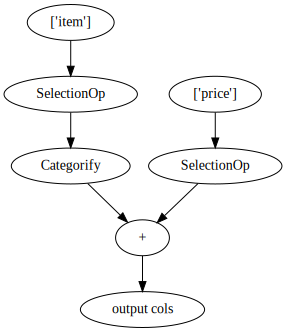

In [9]:
output.graph

In [10]:
workflow = nvt.Workflow(output)
dataset = nvt.Dataset(gdf)

In [11]:
workflow.fit_transform(dataset).to_ddf().compute()

,item,price
0,1,2.5
1,1,2.5
2,2,3.0


# Combining columns using `Categorify`

As Kaggle GMs share in the outstanding [Recsys2020 Tutorial](https://github.com/rapidsai/deeplearning/blob/main/RecSys2020Tutorial/03_1_CombineCategories.ipynb), combining categories can be a very powerful move.

By doing so, we can expose valuable splits to our tree based model that it wouldn't be able to identify otherwise. This technique allows us to tap into the powerful Cross Column or Cross Product features and its applicability goes beyond just tree based models.

`nvtabular` supports this operation natively!

In [12]:
gdf = cudf.DataFrame(data=[['apple', 'red'], ['apple', 'red'], ['apple', 'green'], ['orange', 'red']], columns=['item', 'color'])
gdf

,item,color
0,apple,red
1,apple,red
2,apple,green
3,orange,red


In [13]:
output = [['item', 'color']] >> nvt.ops.Categorify(encode_type='combo', ) # note the column selector to the left of `>>`
                                                                          # it is a list of lists!
                                                                          # the nested list denotes a column group

In [14]:
workflow = nvt.Workflow(output)
dataset = nvt.Dataset(gdf)

In [15]:
workflow.fit_transform(dataset).to_ddf().compute()

,item_color
0,2
1,2
2,1
3,3


In [16]:
cudf.read_parquet(output.op.categories['item_color'])

,item,color
0,<NA>,<NA>
1,apple,green
2,apple,red
3,orange,red


What makes this technique particularly valuable is a built in mechanism for controlling overfitting.

Combining categories with only a couple of examples can prove detrimental -- we might not have enough data to learn anything that would generalize well to unseen data.

`Categorify` supports setting a threshold above which combining categories will take place. Categories of lesser frequency will all be placed in a single bin (that of &lt;NA>).
    
To demonstrate this functionality, let us only combine categories with minimal threshold of 2 examples.

In [17]:
gdf

,item,color
0,apple,red
1,apple,red
2,apple,green
3,orange,red


In [18]:
output = [['item', 'color']] >> nvt.ops.Categorify(encode_type='combo', freq_threshold=2)

In [19]:
workflow = nvt.Workflow(output)
dataset = nvt.Dataset(gdf)

In [20]:
workflow.fit_transform(dataset).to_ddf().compute()

,item_color
0,1
1,1
2,0
3,0


In [21]:
cudf.read_parquet(output.op.categories['item_color'])

,item,color
0,<NA>,<NA>
1,apple,red


# Benchmarking against pandas

In [22]:
import pandas as pd
import numpy as np

In [23]:
colors = pd.DataFrame(data={'color': np.random.choice(['red', 'green', 'blue'], 100_000_000)})

In [24]:
%%time

c = pd.Categorical(colors['color'])

CPU times: user 4.48 s, sys: 475 ms, total: 4.96 s
Wall time: 4.94 s


In [25]:
gcolors = cudf.from_pandas(colors)

In [26]:
%%time

output = ['color'] >> nvt.ops.Categorify()
workflow = nvt.Workflow(output)
dataset = nvt.Dataset(gcolors)
gdf = workflow.fit_transform(dataset).to_ddf().compute()
gdf.head()

CPU times: user 820 ms, sys: 147 ms, total: 966 ms
Wall time: 966 ms


,color
0,3
1,2
2,3
3,1
4,3
